# Create a Model to Classify Cats and Dogs and Save Best Model to reuse in Future.

## Specific Concept that will be covered.

In this process, I'll build practical experience and develop intution around the following concept

- Building data input pipelines using the `tf.keras.preprocessing.image.ImageDataGenerator` class. How can I efficiently work with data on disk to interface with our model?
- Overfitting - what is it?, how to identify it, and how can we prevent it?
- Data Augmentation and Dropout - key techniques to fight overfitting in computer vision tasks that I'll incorporate into data pipeline and image classifier model.

## I'll follow the general machine learning workflow.

1. Examine and understand data
2. Buid an input pipeline
3. Buil my model
4. Train my model
5. Test my model
6. Improve my model/Repeat the process
7. Save my best model 

## Importing Packages

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Download Data and read data from given URL

To build image classifier, I begine by downloading the dataset. The daset I'm using a fitered version of [Dogs vs. cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from kaggle (ultimately, this dataset is provided by Microsoft Research). I'll use ImageDataGenerator from  `tf.keras.preprocessing.image.ImageDataGenerator` which read data from disk.

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin = _URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


## Read dataset from directory 

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_validation  = num_cats_val + num_dogs_val


## Understanding Data

In [8]:
print(f'total training cats images: {num_cats_tr}')
print(f'total training dogs images: {num_dogs_tr}')

print(f'total validation cats images: {num_cats_val}')
print(f'Toatal validation dogs images: {num_dogs_val}')

print(f'Total training images: {total_train}')
print(f'Total validation images: {total_validation}')

total training cats images: 1000
total training dogs images: 1000
total validation cats images: 500
Toatal validation dogs images: 500
Total training images: 2000
Total validation images: 1000


## Setting Model's Parametrs

In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

## Data Augmentation

Overfitting often occure when we have a small number of training examples. One way to fix this problem is to augment our datset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training dataset from existing traning samples by augmenting the samples through random transformation that yield believable-looking images. The goal is that at training time, my model will never see the exact same picture twice. This exposes the model to more aspects of the dats, allowing it to genralize better.

In `tf.keras` I can implement this using the same **imageDataGenerator** class I used before. I can simply pass difference transformations I would want to my dataset as form of augmentations and it'll take care of applying it to the dataset duraning training process.

In [10]:
def plotImage(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

### Flipping the image horizontally

In [11]:
image_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


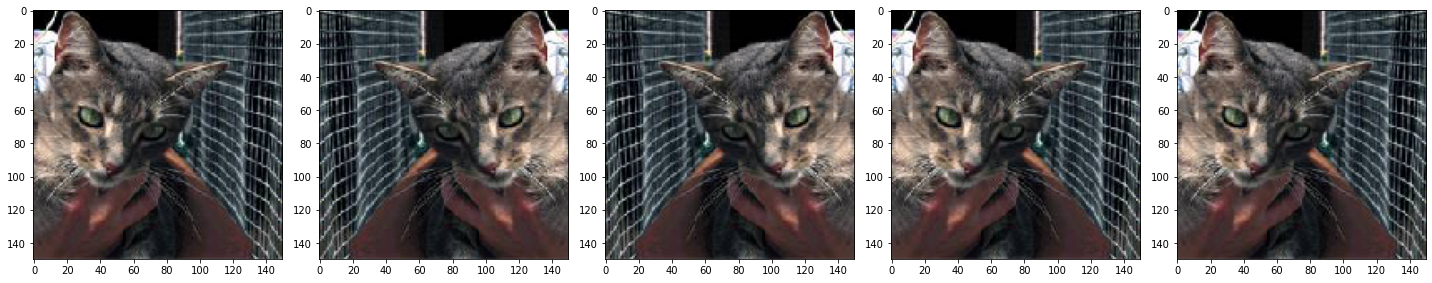

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImage(augmented_images)

### Rotating the image

In [13]:
image_gen = ImageDataGenerator(rescale=1/255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


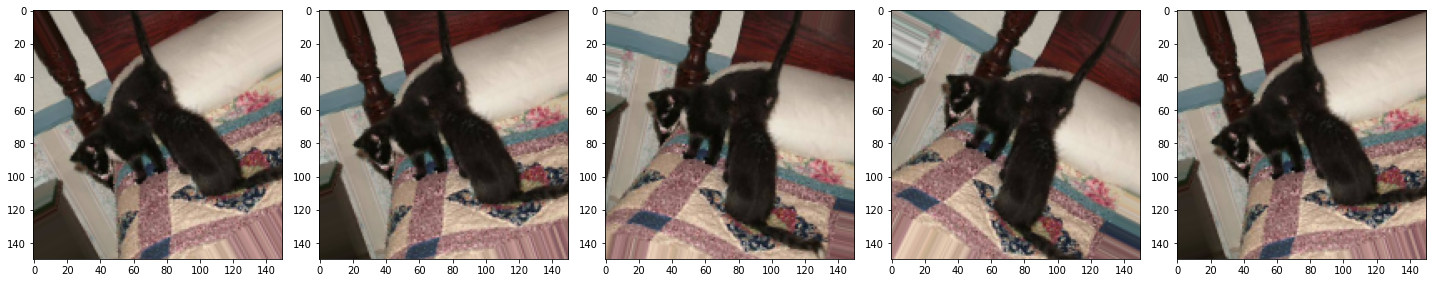

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImage(augmented_images)

### Putting it all together

In [15]:
image_gen_train = ImageDataGenerator(
        rescale=1/255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


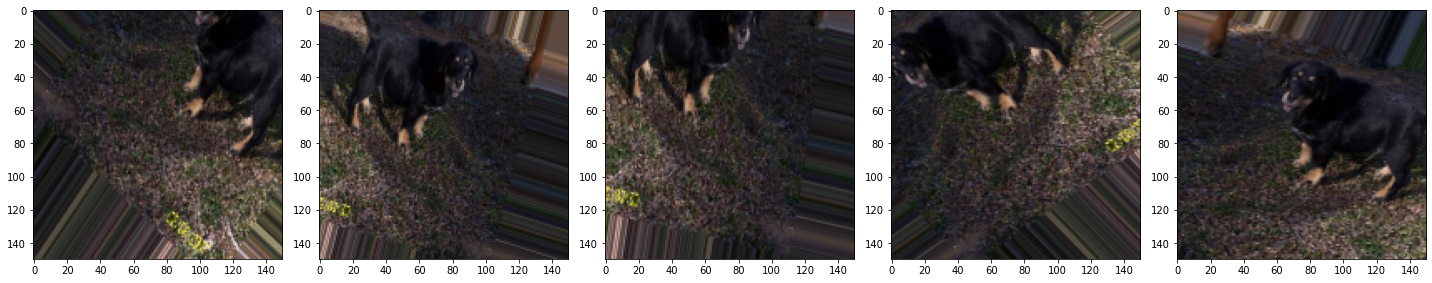

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImage(augmented_images)

## Creating Validation Data Generatation

In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Create Model

### Define the model

The model consist of four convolution blocks with a max pool layer in each of them.

Before the final dense layer, we're also applying a Dropout problility of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we've a fully connected layer with 512 units, with `relu` activation function. The model will output class probabilities for two classes **dogs and cats** using `softmax`.

In [18]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### Compiling the model

As usual, I will use the `adam` optimizer. Since I output a softmax categorization, I'll use `sparse_categorical_crossentropy` as the loss function. I would also like to look at training and validation accuracy on each epoch as I train my network, so I'm passing in the metrics argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Train the model 

It's time I train my network.

Since my batches are coming from a generator (`ImageDataGenerator`), I'll use `fit_generator` instead of `fit`.

In [21]:
epochs=100
history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=epochs,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_validation / float( BATCH_SIZE)))
      )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


20/20 [==============================] - 48s 781ms/step - loss: 0.7140 - accuracy: 0.5025 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 16s 789ms/step - loss: 0.6925 - accuracy: 0.5235 - val_loss: 0.6905 - val_accuracy: 0.5690
Epoch 3/100
20/20 [==============================] - 16s 791ms/step - loss: 0.6875 - accuracy: 0.5625 - val_loss: 0.7157 - val_accuracy: 0.5210
Epoch 4/100
20/20 [==============================] - 16s 789ms/step - loss: 0.6994 - accuracy: 0.5080 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 16s 790ms/step - loss: 0.6888 - accuracy: 0.5175 - val_loss: 0.6846 - val_accuracy: 0.5720
Epoch 6/100
20/20 [==============================] - 16s 787ms/step - loss: 0.6856 - accuracy: 0.5595 - val_loss: 0.6688 - val_accuracy: 0.5960
Epoch 7/100
20/20 [==============================] - 16s 777ms/step - loss: 0.6712 - accuracy: 0.5830 - val_loss: 0.6443 - val_accuracy: 0.6100
Epoc

## Visualizing result of training 

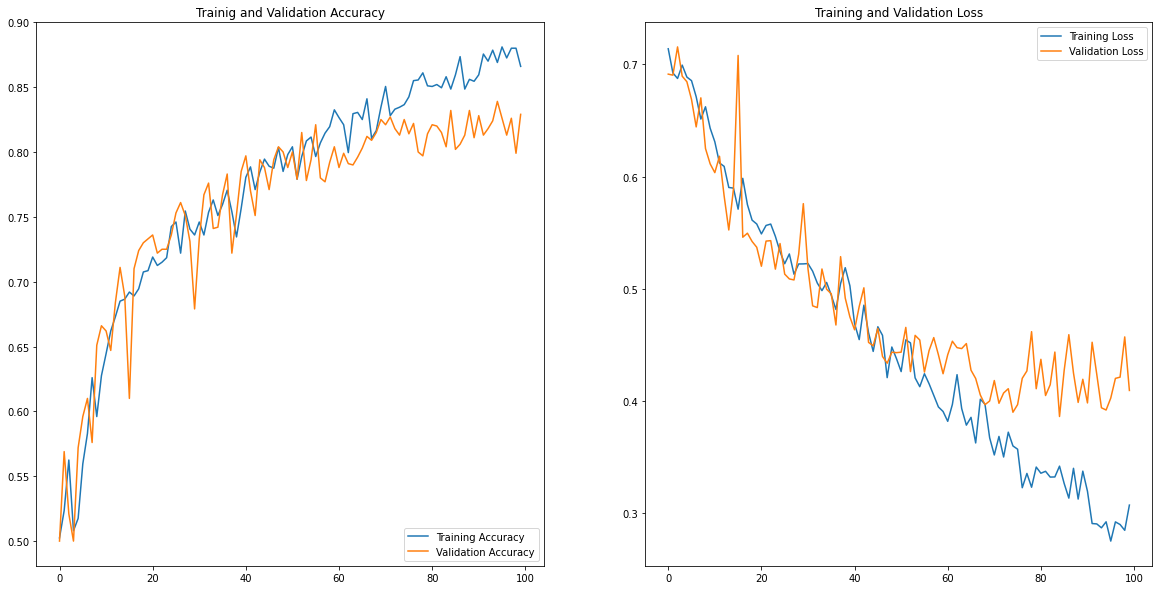

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Trainig and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
image_batch, label_batch = next(iter(train_data_gen))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_batch = np.argmax(predicted_batch, axis=-1)

### Label
- 1 for Dog

- 0 for cat

In [65]:
print(f'Actual Labels: {label_batch[:20]}')
print(f'Predicted Label: {predicted_batch[:20]}')

Actual Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
Predicted Label: [1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0]


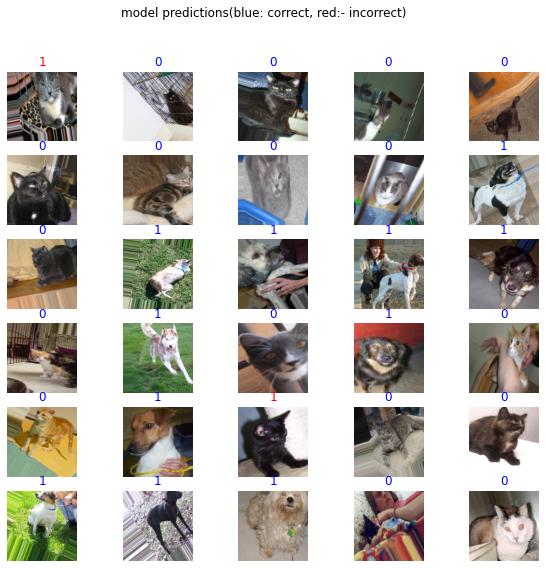

In [70]:
plt.figure(figsize=(10, 9))
for n in range(30):
  plt.subplot(6, 5 , n+1)
  plt.imshow(image_batch[n])
  color = 'blue'if predicted_batch[n] == label_batch[n] else 'red'
  plt.title(predicted_batch[n], color=color)
  plt.axis('off')
  _=plt.suptitle("model predictions(blue: correct, red:- incorrect)")

## Save Model

In [83]:
!pwd

/content


In [84]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [85]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [101]:
now = datetime.now()

export_path_sm = './{}'.format(now.strftime('SaveMode/%d-%m-%Y-%H:%M:%S'))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./SaveMode/29-05-2021-12:07:29

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./SaveMode/29-05-2021-12:07:29/assets


### I've save model as `saved_model.pb`

In [109]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [117]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [118]:
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()
result_batch = tf.squeeze(reloaded_sm_result_batch).numpy()
result_batch = np.argmax(result_batch, axis=-1)

In [119]:
abs(predicted_batch - result_batch).max()

0

## Download to local disk

In [120]:
!zip -r model.zip {export_path_sm}

  adding: SaveMode/29-05-2021-12:07:29/ (stored 0%)
  adding: SaveMode/29-05-2021-12:07:29/variables/ (stored 0%)
  adding: SaveMode/29-05-2021-12:07:29/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: SaveMode/29-05-2021-12:07:29/variables/variables.index (deflated 67%)
  adding: SaveMode/29-05-2021-12:07:29/assets/ (stored 0%)
  adding: SaveMode/29-05-2021-12:07:29/saved_model.pb (deflated 89%)


In [121]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>